In [ ]:
from fastai.text import *
from fastai import *

In [24]:
df = pd.read_csv("data/bank_data.csv")
df.head()

,tweet,sentiment,date,weekday,hour,followers,description
0,because they answered you doesnt mean they are...,0,2019-03-06 05:15:05,2.0,5.0,521.0,arab academy alumni member of the nautical in...
1,because they answered you doesnt mean they are...,0,2019-03-06 05:15:05,2.0,5.0,521.0,arab academy alumni member of the nautical in...
2,there you have it,0,2019-03-06 05:03:39,2.0,5.0,708.0,without christs mercy my life is messychartere...
3,ok i understand and i also have some questions...,0,2019-03-06 05:01:35,2.0,5.0,1949.0,am a blogger pr and also a music producer
4,i have not been able to use my first bank appl...,1,2019-03-06 04:34:43,2.0,4.0,14.0,principal consultant green consulting


In [ ]:
import math

In [ ]:
df_1 = df.loc[:,["tweet","sentiment"]] ##since we only need the tweet and the sentiment

In [ ]:
## split the data into  train and validation

split = math.floor((len(df_1) - len(df_1)*0.1))
train_df = df_1[:split].reset_index()
valid_df = df_1[split:].reset_index()

In [ ]:
valid_df.drop("index",axis=1,inplace=True)
train_df.drop("index",axis=1,inplace=True)

In [ ]:
## convert the sentiment from 0 and 1 to positive and negative
mm = {
    1:"pos",
    0:"neg"
}
# valid_df["label"] = valid_df["sentiment"].map(mm)
# train_df["label"] = train_df["sentiment"].map(mm)

df_1["label"] = df_1["sentiment"].map(mm)

In [28]:
# valid_df.drop("sentiment",axis=1,inplace=True)
# train_df.drop("sentiment",axis=1,inplace=True)
df_1.drop("sentiment",axis=1,inplace=True)
df_1.head()

,tweet,label
0,because they answered you doesnt mean they are...,neg
1,because they answered you doesnt mean they are...,neg
2,there you have it,neg
3,ok i understand and i also have some questions...,neg
4,i have not been able to use my first bank appl...,pos


In [ ]:
valid_df.head()

,tweet,label
0,fed govt managed by amp is turning to be ...,neg
1,whats your procedure to report banks defaultin...,pos
2,is really toying with meanyway ive sent you pe...,pos
3,guys have left me no choice but to make an off...,pos
4,our workshop didnt have as many attendees as ...,neg


In [ ]:
## remove the nan rows
d = df_1.isna().iloc[:,0] ==True
f = d[d]
dd = list(f.index)
df_1.drop(dd,axis=0,inplace=True)

In [31]:
df_1.head()

,tweet,label
0,because they answered you doesnt mean they are...,neg
1,because they answered you doesnt mean they are...,neg
2,there you have it,neg
3,ok i understand and i also have some questions...,neg
4,i have not been able to use my first bank appl...,pos


In [ ]:
df_2 = df_1.copy()
df_2.drop("sentiment",axis=1,inplace=True)

In [ ]:
bs=30

In [ ]:
path = "data"

create a data bunch of a specific batch size for the text file
then the data is split into train and validation set of 10%. Other text preprocessing are done like removing the rare words

In [ ]:

data_m = (TextList.from_df(df_1,path=path)
          .random_split_by_pct(0.1)
          .label_for_lm()
          .databunch(bs=bs)
         )

In [ ]:
data_m.save('tmp_lm') ##save the token and words

In [34]:
data_m.path

PosixPath('drive/bank-sentiment')

In [ ]:
data_m = load_data(path, 'tmp_lm', bs=bs)

In [36]:
data_m.show_batch()

idx,text
0,to use my first bank application the response i got is network error which is not xxbos i recharged a number i was debited but the transaction was not a successful one can i be refunded as soon as possible xxbos thanks i ve confirmed it xxbos pls is it possible to reactivate my dormant acct online perhaps what s d way to xxbos i have already gotten an email
1,3weeks now they ai nt doing nothing in your branches xxunk been to ur xxbos i try to load airtime of 3500 from my account this morning using code 894 unfortunately i was debited w xxbos good afternoon i was having xxunk naira in my account then someone sent 1500 into my account which is s xxbos any news xxbos here is the xxunk from the alert xxbos good morning
2,for over 48hrs now no response xxbos good evening i made some transfer on the 1st of this month but the person i transfer the money to is yet xxbos account name xxunk xxunk account number xxunk of xxunk and 400 was debited from m xxbos i transfer money to gtbank three times on saturday till now did nt deliver and xxbos i have sent you several messages on this
3,in one trouble with xxbos please i have been xxunk with my account which i created on the phone and deposited some amount of mo xxbos please you people should attend to this nonsense make e for no cause fight o i m talking small small now xxbos i m literally tired i mean is nt nigeria hard enough xxunk xxbos i have been waiting for the money to be
4,and money have been deducted and airtime have not been given xxbos good morning please i want my card to xxunk web or online payment for example like being able to pay xxbos the problem now is the app is not even working on my phone xxbos i did a airtime transfer to a person and he was not credited and did not get a xxunk over 24hrs xxbos if


## Model using Fastai ULMFIT
The process involve training a language model on a corpus like wikitext103 and the language model is fintuned to create a language model for our specific task data and then the language model built is used to enhance our model classification of text using transfer learning. The process is achieved with different techniques like **descriminative learning rate**, **slanten triangular learning rate** and **model freezing and unfreezing**

### Language Model finetuning

In [ ]:
learn = language_model_learner(data_m, arch=AWD_LSTM, drop_mult=0.3)

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


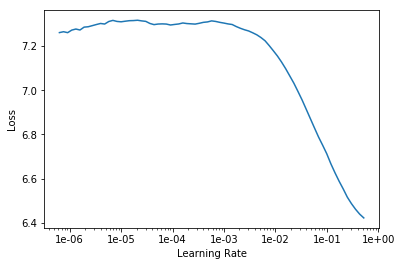

In [39]:
learn.recorder.plot(skip_end=15)

In [42]:
learn.fit_one_cycle(1, max_lr=slice(1e-3,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.000896,4.323910,0.220159,00:06


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


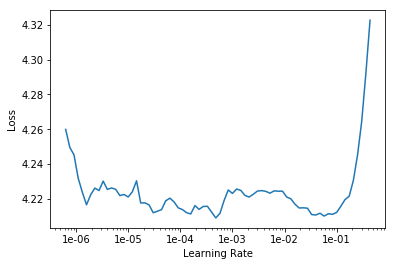

In [45]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


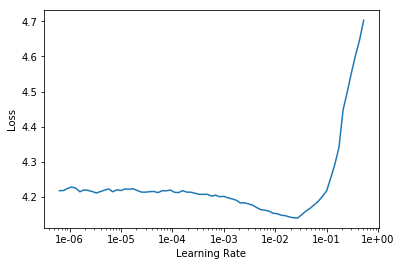

In [51]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [52]:
learn.fit_one_cycle(20, max_lr=slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.183439,4.259485,0.226032,00:07
1,4.100864,4.162446,0.237063,00:07
2,3.980720,4.071305,0.246190,00:07
3,3.836182,3.988719,0.253889,00:07
4,3.644904,3.949925,0.265079,00:07
5,3.446592,3.928688,0.267143,00:07
6,3.204629,3.971375,0.273016,00:07
7,2.958275,4.009604,0.278968,00:07
8,2.729325,4.051416,0.278571,00:07
9,2.508374,4.125082,0.279127,00:07


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "please check"
N_WORDS = 5
N_SENTENCES = 2

test how good the model is

In [56]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

please check your dm and respond i
please check your dm xxbos your own


In [ ]:
learn.save_encoder('fine_tuned_enc')

## Model Classification

In [ ]:
split = math.floor((len(df_1) - len(df_1)*0.1))
train_df = df_1[:split].reset_index()
valid_df = df_1[split:].reset_index()

In [ ]:
mm = {
    1:"pos",
    0:"neg"
}
valid_df["label"] = valid_df["sentiment"].map(mm)
train_df["label"] = train_df["sentiment"].map(mm)

In [ ]:
valid_df.drop(["index","sentiment"],axis=1,inplace=True)
train_df.drop(["index","sentiment"],axis=1,inplace=True)

In [ ]:
data_clas = (TextList.from_df(df_1,vocab=data_m.vocab,path=path)
             .random_split_by_pct(0.1)
             .label_from_df(cols="label")
             .databunch(bs=bs)
            )

In [ ]:
data_clas.save('data_clas.pkl')


In [60]:
data_clas.path

PosixPath('drive/bank-sentiment')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [62]:
data_clas.show_batch()

text,target
xxbos please note that i do nt need the session i d but the receipt i can print out so i can xxunk to the school as proof of evidence,neg
xxbos your acct xxunk xxrep 4 x xxunk has been debited with ngn2 xxrep 4 0 on xxunk 18 xxunk xxunk by qs894 1013 xxrep 4 0 xxunk,pos
xxbos the transaction was done twice 1 xxrep 4 0 each total of 2 xxrep 4 0 and 1 xxrep 4 0 has been reversed while the xxunk,pos
xxbos good day i used my first bank card in first atm and it debited me and did nt give me the money reversed the money back thanks,pos
xxbos if i ca nt be able to enjoy my so called bank service so what do i gain to mail gtb to confirm my 9000 th,pos


And since we've created a pretrained language model for the data, load it weight to the new defined architecture and used it for classification

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


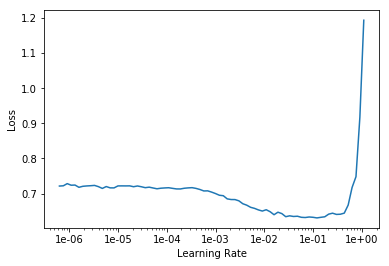

In [65]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.600698,0.570455,0.732977,00:05
1,0.564923,0.453818,0.787717,00:05
2,0.539178,0.387338,0.837116,00:05


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

### Gradual freezing
the last method is the gradual freezing. in image model it is easier to unfreeze out once, but in language model and rnn we need to do the gradually so we wont loose information

In [81]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(4e-2/(2.6**4),4e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.523534,0.460183,0.783712,00:06
1,0.453589,0.381261,0.838451,00:06


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


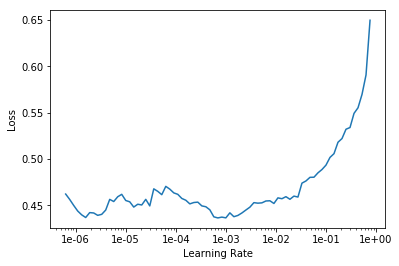

In [86]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [91]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.418526,0.379893,0.841122,00:09
1,0.413469,0.364953,0.841122,00:09


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [99]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.378544,0.355114,0.843792,00:12


### The final model accuracy is 84% on a very small dataset <7k

In [ ]:
learn.save("final")

In [102]:
learn.predict(df_1.iloc[5,0])

(Category pos, tensor(1), tensor([0.0657, 0.9343]))

In [ ]:
valid_df.iloc[5,1]

'pos'

In [ ]:
valid_df.iloc[0,0]

'our  workshop didnt have as many attendees as the last year we did it but these ones are from the  of'

In [ ]:
learn.save("final")

## Inference

In [ ]:
mm = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [ ]:
mm.load("final")

In [ ]:
mm.predict(valid_df.iloc[5,0])

(Category pos, tensor(1), tensor([0.2016, 0.7984]))

InFerence method

In [ ]:
path="drive/bank-sentiment/"

In [ ]:
bs=30

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [16]:
data_clas.show_batch()

text,target
xxbos please note that i do nt need the session i d but the receipt i can print out so i can xxunk to the school as proof of evidence,neg
xxbos so in total 3 times failed recharge of 1000 that did nt work but i was debited 1 remaining on the 18 and 2 on the 19,pos
xxbos your acct xxunk xxrep 4 x xxunk has been debited with ngn2 xxrep 4 0 on xxunk 15 24 57 by qs894 xxunk xxrep 4 0 xxunk,pos
xxbos no problem take the n200 the time wey i need am una no attend to me i do nt need your hands on my account now xxunk,neg
xxbos i currently so not have access to my mobile app but i have my number how can i request my bank statement to be sent to me,neg


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.load("final")

In [23]:
learn.predict('ok i understand and i also have some questions to ask about an account my dad opened for me and my sibli')

(Category neg, tensor(0), tensor([0.5276, 0.4724]))